# Import library

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import functools

## Random seed

In [54]:
RANDOM_SEED = 99
np.random.seed(RANDOM_SEED)

# Function to transform the data

In [55]:
# Function to transfer from dBW to W (power)
def db2pow(db: float) -> float:
    return 10**(db/10)

# Function to transfer from W to dBW (power)
def pow2db(pow: float) -> float:
    return 10*np.log10(pow)

# Hermitian transpose of a matrix
def HermTranspose(x: np.ndarray) -> np.ndarray:
    return x.conj().T

def chanGen(zeta: float, d: float, dim1: int, dim2: int) -> np.ndarray:
    """Function to generate Rayleigh fading channel coefficients

    Args:
        zeta: ξ is the path loss exponent
        d: the distance between the transmitter and the receiver
        dim1: the number of rows in the channel matrix
        dim2: the number of columns in the channel matrix
    """
    pl_ref: float = -30                                    # pathloss (dBW) at reference distance
    pl: float = db2pow(pl_ref - 10*zeta*np.log10(d))       # pathloss model at distance d
    y: np.ndarray = np.sqrt(0.5*pl)*(np.random.randn(dim1,dim2)\
        + 1j*np.random.randn(dim1,dim2))            # Rayleigh distribution
    return y

## Parameters

In [56]:
sigma = db2pow(-75)                                                                 # noise power
N = 8                                                                               # number of transmit antennas
Nris = 32                                                                           # number of RIS elements
number_of_users = 4                                                                 # number of users
number_of_eavesdroppers = 2                                                         # number of eavesdroppers
zetaAI = 2.2                                                                        # Path loss exponent of the channel between the Alice and the RIS
zetaIB = 2.5                                                                        # Path loss exponent of the channel between the legitimate receivers and the RIS
zetaIE = 2.5                                                                        # Path loss exponent of the channel between the eavesdroppers and the RIS
zetaAB = 3.5                                                                        # Path loss exponent of the channel between the Alice and the legitimate receivers
zetaAE = 3.5                                                                        # Path loss exponent of the channel between the Alice and the eavesdroppers

dAI = 50                                                                            # distance between Alice and the RIS
dv = 2                                                                              # Vertical distance between the Alice and the Eve and Bob
dABh = np.random.uniform(5, 10, size=number_of_users)                               # Horizontal distance between Alice and the legitimate receivers
dAEh = np.random.uniform(50, 150, size=number_of_eavesdroppers)                     # Horizontal distance between Alice and the eavesdroppers
dAB = [np.sqrt(dABh[i]**2 + dv**2) for i in range(number_of_users)]                 # Distance between Alice and the legitimate receivers
dAE = [np.sqrt(dAEh[i]**2 + dv**2) for i in range(number_of_eavesdroppers)]         # Distance between Alice and the eavesdroppers
dIB = [np.sqrt((dABh[i]-dAI)**2 + dv**2) for i in range(number_of_users)]           # Distance between the legitimate receivers and the RIS
dIE = [np.sqrt((dAEh[i]-dAI)**2 + dv**2) for i in range(number_of_eavesdroppers)]   # Distance between the eavesdroppers and the RIS


In [57]:
def normalise_beamforming_vectors(w: np.ndarray) -> np.ndarray:
    """Function to normalise the beamforming vectors

    Args:
        w: the beamforming vectors
    """
    total_norm = 0
    for i in range(number_of_users):
        total_norm += np.linalg.norm(w[i])
    for i in range(number_of_users):
        w[i] = w[i] / total_norm
    return w

def generate_random_beamforming_vector():
  '''
  Generate one random beamforming vector
  '''
  return np.random.uniform(-1, 1, (N, 1)) + 1j * np.random.uniform(-1, 1, (N, 1))

def generate_random_beamforming_vectors():
    # Generate random complex numbers for each element of the beamforming vector
    beamforming_vectors = [generate_random_beamforming_vector() for _ in range (number_of_users)]
    
    # Normalize the vectors
    beamforming_vectors = normalise_beamforming_vectors(beamforming_vectors)
    return beamforming_vectors
    #w: list of beamforming vectors, length = number of users, elements are N x 1

def generate_random_theta():
    theta = np.random.uniform(-np.pi, np.pi, (1, Nris))
    theta = np.exp(1j * theta)
    return theta
    #theta: phase shift of RIS, size 1 x Nris

def generate_random_theta_angles(size: int):
  """
    Generate a random vector of angles from -pi to pi
  """
  return np.random.uniform(-np.pi, np.pi, size=(1, size))

def theta_angles_to_theta_vector(angles: np.ndarray[np.float64]) -> np.ndarray[np.complex128]:
  """
    Convert a vector of angles to a vector of complex numbers on the unit circle
  """
  return np.exp(1j * angles)

def theta_vector_to_theta_angles(theta: np.ndarray[np.complex128]) -> np.ndarray[np.float64]:
  """
    Convert a vector of complex numbers on the unit circle to a vector of angles
  """
  return np.angle(theta)

def generateChannel():
    normFact = 1/np.sqrt(sigma)
    Hai = chanGen(zetaAI, dAI, Nris, N)                                                         # Alice to RIS channel
    hib = [normFact*chanGen(zetaIB, dIB[i], 1, Nris) for i in range(number_of_users)]           # Channel between the RIS and the legitimate receivers
    hie = [normFact*chanGen(zetaIE, dIE[i], 1, Nris) for i in range(number_of_eavesdroppers)]   # Channel between the RIS and the eavesdroppers
    hab = [normFact*chanGen(zetaAB, dAB[i], 1, N) for i in range(number_of_users)]              # Channel between Alice and the legitimate receivers
    hae = [normFact*chanGen(zetaAE, dAE[i], 1, N) for i in range(number_of_eavesdroppers)]      # Channel between Alice and the eavesdroppers
    return Hai, hib, hie, hab, hae

    #Hai: Channel between Alice and RIS: Nris x N  
    #hib: Channel between RIS and users: List of length number_of_users, elements are 1 x Nris
    #hab: Channel between Alice and users: List of length number_of_users, elements are 1 x N
    #hie: Channel between RIS and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x Nris
    #hae: Channel between Alice and eavesdroppers: List of length number_of_eavesdroppers, elements are 1 x N

In [58]:
# Reseed
# np.random.seed(RANDOM_SEED)

# Channel generation
Hai, hib, hie, hab, hae = generateChannel()

# Generate random theta and w
theta_init = generate_random_theta()
w_init = generate_random_beamforming_vectors()

# Objective Function

In [59]:
def secrecy_rate_objective_function(theta, w) -> float:
    secrecy_rate: float = 0
    for k in range(number_of_users):
        R_bk = []
        # Legitimate user k
        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk
        C_bk = np.log2(1 + gamma_bk)
        
        for m in range(number_of_eavesdroppers):
            # Eavesdropper i
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            C_em = np.log2(1 + gamma_em)
            R_bk.append(C_bk - C_em)
        
        secrecy_rate += max(min(R_bk),0)
    return secrecy_rate

In [60]:
print(theta_init)
print("distance between Alice and the receivers: ", dAB)
print("distance between Alice and the eavesdroppers: ", dAE)
print("Secrecy Rate:", secrecy_rate_objective_function(theta_init, w_init))

[[ 0.88048122+0.47408102j  0.10675779-0.99428506j -0.94121722+0.33780192j
  -0.51552239-0.85687611j  0.98551347-0.16959717j  0.1734521 -0.98484231j
   0.05972855-0.99821466j -0.82186107+0.56968797j -0.64812937+0.76153025j
   0.94798661+0.31831021j -0.58631416-0.81008376j  0.30854288-0.95121044j
  -0.88320766-0.46898212j -0.36293885+0.93181296j -0.8274319 -0.56156608j
  -0.90636523+0.42249504j  0.95027299-0.31141812j  0.82084652+0.57114883j
  -0.89074293-0.45450746j -0.68946858+0.72431559j  0.95427824-0.2989198j
   0.98565906+0.16874896j  0.82615517-0.56344267j -0.45260546+0.89171088j
  -0.3844826 +0.92313224j -0.97945512+0.20166227j -0.83626362-0.54832761j
   0.26845845+0.96329127j  0.87334229+0.48710702j -0.93345363-0.3586981j
  -0.70376125-0.71043656j  0.68661103+0.72702496j]]
distance between Alice and the receivers:  [np.float64(8.597260577730964), np.float64(7.704507320858385), np.float64(9.344025672091696), np.float64(5.531459234567628)]
distance between Alice and the eavesdroppe

# Method

## Gradient Descent for Maximization (GD)

In [61]:
def compute_gradient_w(theta, w):
    grad_w = []
    Z_e_max = [] #Z_e_max[k] = Z_e_max for user k
    gamma_e_max = [] #gamma_e_max[k] = gamma_e_max for user k
    Z_b = [] #Z_b[k] = Z_bk
    gamma_b = [] #gamma_b[k] = gamma_bk
    counted = [] #counted[k] = true if gamma_k > gamma_e_max[k]
    

    #Precalculation 
    for k in range (number_of_users):
        gamma_e = []
        for m in range (number_of_eavesdroppers):
            Z_em = hie[m] @ np.diag(theta.flatten()) @ Hai + hae[m]
            numGamma_em = np.abs(Z_em @ w[k])**2
            denGamma_em = 1 + np.sum([np.abs(Z_em @ w[j])**2 for j in range(number_of_users) if j != k])
            gamma_em = numGamma_em/denGamma_em
            gamma_e.append(gamma_em)
        
        gamma_e_max.append(max(gamma_e))
        index_e_max = gamma_e.index(max(gamma_e))
        Z_e = hie[index_e_max] @ np.diag(theta.flatten()) @ Hai + hae[index_e_max]
        Z_e_max.append(Z_e)

        Z_bk = hib[k] @ np.diag(theta.flatten()) @ Hai + hab[k]
        numGamma_bk = np.abs(Z_bk @ w[k])**2
        denGamma_bk = 1 + np.sum([np.abs(Z_bk @ w[i])**2 for i in range(number_of_users) if i != k])
        gamma_bk = numGamma_bk/denGamma_bk

        Z_b.append(Z_bk)
        gamma_b.append(gamma_bk)

        counted.append(gamma_bk > gamma_e[index_e_max])


    #Calculating grad for i-th beamforming vector
    for i in range (number_of_users):
        grad = np.zeros((N, 1))
        #print("grad_shape =", grad.shape)
        for k in range (number_of_users):
            if (counted[k] == False):
                continue
            if (k == i):
                num_grad_C_bk_to_w_k = 2 * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[k])
                den_grad_C_bk_to_w_k = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_bk_to_w_k = num_grad_C_bk_to_w_k / den_grad_C_bk_to_w_k

                num_grad_C_e_max_to_w_k = 2 * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[k])
                den_grad_C_e_max_to_w_k = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k]))
                grad_C_e_max_to_w_k = num_grad_C_e_max_to_w_k / den_grad_C_e_max_to_w_k
                
                #print("num_grad_C_e_max_to_w_k", num_grad_C_e_max_to_w_k.shape)
                #print("den_grad_C_e_max_to_w_k", den_grad_C_e_max_to_w_k.shape)
                grad = grad - (grad_C_bk_to_w_k - grad_C_e_max_to_w_k)
            else:
                num_grad_C_bk_to_w_i = -2 * abs(Z_b[k] @ w[k]) * (HermTranspose(Z_b[k]) @ Z_b[k] @ w[i])
                den_grad_C_bk_to_w_i = (1 + gamma_b[k]) * np.log(2) * (1 + sum([abs(Z_b[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_bk_to_w_i = num_grad_C_bk_to_w_i / den_grad_C_bk_to_w_i

                num_grad_C_e_max_to_w_i = -2 * abs(Z_e_max[k] @ w[k]) * (HermTranspose(Z_e_max[k]) @ Z_e_max[k] @ w[i])
                den_grad_C_e_max_to_w_i = (1 + gamma_e_max[k]) * np.log(2) * (1 + sum([abs(Z_e_max[k] @ w[j]) for j in range (number_of_users) if j != k])) ** 2
                grad_C_e_max_to_w_i = num_grad_C_e_max_to_w_i / den_grad_C_e_max_to_w_i

                grad = grad - (grad_C_bk_to_w_i - grad_C_e_max_to_w_i)
            
        grad_w.append(grad)
    return grad_w

def compute_gradient_theta(theta, w, epsilon=1e-3):
    grad_theta = []
    for i in range(Nris):
        theta_plus = deepcopy(theta)
        theta_plus[0, i] += epsilon + epsilon*1j
        theta_minus = deepcopy(theta)
        theta_minus[0, i] -= epsilon + epsilon*1j
        grad_theta_i = (secrecy_rate_objective_function(theta_plus, w) - secrecy_rate_objective_function(theta_minus, w))/(2*epsilon)
        grad_theta.append(grad_theta_i)
            
    return np.array(grad_theta).reshape(1, Nris)



def gradient_descent_update(w, theta, learning_rate):
    grad_w = compute_gradient_w(theta, w)
    grad_theta = compute_gradient_theta(theta, w)
    w_new = [w[i] - learning_rate * grad_w[i] for i in range (number_of_users)]
    total_norm = 0
    for i in range (number_of_users):
        total_norm += np.linalg.norm(w_new[i]) ** 2
    for i in range (number_of_users):
        w_new[i] = w_new[i] / np.sqrt(total_norm)
        
    theta_new = theta - learning_rate * grad_theta
    theta_new = np.exp(1j * np.angle(theta_new))

    return w_new, theta_new



In [62]:
# Reseed first
np.random.seed(RANDOM_SEED)

# Gradient Descent Algorithm
num_cycles = 500
learning_rate = 0.01
theta_GD = generate_random_theta()
w_GD = generate_random_beamforming_vectors()
print("Initial Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))
current_secrecy_rate = secrecy_rate_objective_function(theta_init, w_init)

GD_results = []
GD_results.append(current_secrecy_rate)

for i in range(num_cycles):
    w_new, theta_new = gradient_descent_update(w_GD, theta_GD, learning_rate)
    new_secrecy_rate = secrecy_rate_objective_function(theta_new, w_new)
    # print(new_secrecy_rate)
    if (new_secrecy_rate - current_secrecy_rate) < 1e-9:
        print("Converged")
        break
    w_GD = w_new
    theta_GD = theta_new
    GD_results.append(new_secrecy_rate)
    current_secrecy_rate = new_secrecy_rate

print(GD_results)
print("Final Secrecy Rate GD:", secrecy_rate_objective_function(theta_GD, w_GD))

Initial Secrecy Rate GD: [[1.20802389]]
Converged
[array([[1.03043829]]), array([[7.25774395]]), array([[9.25334541]]), array([[10.59563882]]), array([[11.63103313]]), array([[12.41924569]]), array([[13.0206543]]), array([[13.50995264]]), array([[13.91082582]]), array([[14.23753364]]), array([[14.50226947]]), array([[14.71633216]]), array([[14.888801]]), array([[15.02699757]]), array([[15.13636794]]), array([[15.22217283]]), array([[15.28839602]]), array([[15.3382977]]), array([[15.37460077]]), array([[15.39961009]]), array([[15.41529282]]), array([[15.42333505]]), array([[15.42518351]])]
Final Secrecy Rate GD: [[15.42518351]]


## Particle Swarm Optimization (PSO)

In [63]:
class PSOParticle:
  def __init__(self) -> None:
    self.theta = generate_random_theta_angles(Nris)
    self.w = generate_random_beamforming_vectors()
    self.best_theta = deepcopy(self.theta)
    self.best_w = deepcopy(self.w)
    self.best_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.best_theta), self.best_w)
    self.velocity_theta = np.zeros((1, Nris))
    self.velocity_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  def update_velocity(self, inertia, c1, c2, global_best_theta, global_best_w):
    self.velocity_theta = inertia * self.velocity_theta + c1 * np.random.rand() * (self.best_theta - self.theta) + c2 * np.random.rand() * (global_best_theta - self.theta)
    self.velocity_w = [inertia * self.velocity_w[i] + c1 * np.random.rand() * (self.best_w[i] - self.w[i]) + c2 * np.random.rand() * (global_best_w[i] - self.w[i]) for i in range(number_of_users)]

  def update_position(self):
    self.theta = self.theta + self.velocity_theta
    self.theta = np.exp(1j * np.angle(self.theta))
    self.w = [self.w[i] + self.velocity_w[i] for i in range(number_of_users)]
    total_norm = 0
    for i in range (number_of_users):
        total_norm += np.linalg.norm(self.w[i])
    for i in range(number_of_users):
        self.w[i] = self.w[i] / total_norm


  def update_best(self):
    current_secrecy_rate = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)
    if current_secrecy_rate > self.best_secrecy_rate:
      self.best_secrecy_rate = current_secrecy_rate
      self.best_theta = deepcopy(self.theta)
      self.best_w = deepcopy(self.w)

In [64]:
def dynamic_inertia(i, max_iter, inertia_max, inertia_min):
  E_t = float((max_iter - i - 1)/max_iter)
  inertia = inertia_min + (inertia_max - inertia_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)
  return inertia

In [65]:
def PSO_optimize_w_theta(max_iter: int, num_particles: int, w_min: float, w_max: float, c1: float, c2: float):
  particles = [PSOParticle() for _ in range(num_particles)]
  global_best_secrecy_rate = -np.inf
  global_best_theta = np.zeros((1, Nris))
  global_best_w = [np.zeros((N, 1)) for i in range(number_of_users)]

  results_secrecy_rate = []

  for iteration in range(max_iter):
    inertia = dynamic_inertia(iteration, max_iter, w_max, w_min)

    for particle in particles:
      particle.update_velocity(inertia, c1, c2, global_best_theta, global_best_w)
      particle.update_position()
      particle.update_best()

      if particle.best_secrecy_rate > global_best_secrecy_rate:
        global_best_secrecy_rate = particle.best_secrecy_rate
        global_best_theta = deepcopy(particle.best_theta)
        global_best_w = deepcopy(particle.best_w)

    results_secrecy_rate.append(global_best_secrecy_rate)

  return results_secrecy_rate

In [66]:
# Reseed
np.random.seed(RANDOM_SEED)

# PSO Algorithm
max_iter = 500
num_particles = 100
w_min = 0.4
w_max = 0.9
c1 = 1.5
c2 = 1.5

PSO_results = PSO_optimize_w_theta(max_iter, num_particles, w_min, w_max, c1, c2)
print("Initial Secrecy Rate PSO:", PSO_results[0])
print(PSO_results)
print("Final Secrecy Rate PSO:", PSO_results[-1])

Initial Secrecy Rate PSO: [[7.37571871]]
[array([[7.37571871]]), array([[7.60238494]]), array([[7.73398794]]), array([[8.51153662]]), array([[8.62641152]]), array([[8.81537602]]), array([[8.98830174]]), array([[9.20426518]]), array([[9.25911106]]), array([[9.49334978]]), array([[9.5921237]]), array([[9.72275732]]), array([[9.82335168]]), array([[9.86742539]]), array([[10.11245983]]), array([[10.23437598]]), array([[10.28036915]]), array([[10.3009869]]), array([[10.37386918]]), array([[10.40149862]]), array([[10.44998162]]), array([[10.51179241]]), array([[10.51748158]]), array([[10.54186235]]), array([[10.55886425]]), array([[10.58057994]]), array([[10.64452847]]), array([[10.69009392]]), array([[10.7672178]]), array([[10.8456996]]), array([[10.9062326]]), array([[10.93785278]]), array([[11.03341997]]), array([[11.05919945]]), array([[11.06008665]]), array([[11.11730241]]), array([[11.13231305]]), array([[11.1777166]]), array([[11.18535334]]), array([[11.19845816]]), array([[11.2173957

## Genetic Algorithm (GA)

In [51]:
class GAIndividual:
  def __init__(self, theta: np.ndarray[np.float64] = None, w: np.ndarray[np.complex128] = None) -> None:
    if theta is None:
      self.theta = generate_random_theta_angles(Nris)
    else:
      self.theta = theta

    if w is None:
      self.w = generate_random_beamforming_vectors()
    else:
      self.w = w

    self.fitness = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)

  def update_fitness(self):
    self.fitness = secrecy_rate_objective_function(theta_angles_to_theta_vector(self.theta), self.w)


class GAPopulation:
  def __init__(self, population_size: int, crossover_rate: float = 0.85, mutation_rate: float = 0.3) -> None:
    self.population_size = population_size
    self.individuals = [GAIndividual() for _ in range(population_size)]
    self.crossover_rate = crossover_rate
    self.mutation_rate = mutation_rate

  def sort_population(self):
    self.individuals.sort(key=lambda x: x.fitness, reverse=True)

  def filter_population(self):
    self.sort_population()
    self.individuals = self.individuals[:self.population_size]

  def add_individual(self, individual: GAIndividual):
    self.individuals.append(individual)

  def select_parents(self) -> tuple[GAIndividual, GAIndividual]:
    parents = np.random.choice(self.individuals, 2, replace=False)
    return parents[0], parents[1]
  
  def crossover(self, parent1: GAIndividual, parent2: GAIndividual) -> GAIndividual:
    theta1, w1 = parent1.theta, parent1.w
    theta2, w2 = parent2.theta, parent2.w
    theta_child = (theta1 + theta2) / 2
    w_child = [(w1[i] + w2[i]) / 2 for i in range(number_of_users)]
    return GAIndividual(theta_child, w_child)
  
  def mutate(self, individual: GAIndividual) -> GAIndividual:
    if np.random.rand() < self.mutation_rate:
      mutation_index = np.random.randint(0, Nris)
      individual.theta[0, mutation_index] = np.random.uniform(-np.pi, np.pi)
      mutation_index = np.random.randint(len(individual.w))
      individual.w[mutation_index] = generate_random_beamforming_vector()
      individual.update_fitness()

    return individual
  
def GA_optimize_w_theta(population_size: int, max_iter: int, crossover_rate: float = 0.85, mutation_rate: float = 0.85):
  population = GAPopulation(population_size, crossover_rate, mutation_rate)
  population.sort_population()
  results_secrecy_rate = []
  results_secrecy_rate.append(population.individuals[0].fitness)

  for _ in range(max_iter):
    # Crossover
    for _ in range(population_size // 2):
      if np.random.rand() < population.crossover_rate:
        parent1, parent2 = population.select_parents()
        child = population.crossover(parent1, parent2)
        population.add_individual(child)

    # Mutation
    for individual in population.individuals:
      population.mutate(individual)

    # Filter
    population.filter_population()

    results_secrecy_rate.append(population.individuals[0].fitness)

  return results_secrecy_rate

In [67]:
population_size = 100
num_generations = 500
crossover_rate = 0.85
mutation_rate = 0.3

# Reseed
np.random.seed(RANDOM_SEED)

# GA Algorithm
GA_results = GA_optimize_w_theta(population_size, num_generations, crossover_rate, mutation_rate)
print("Initial Secrecy Rate GA:", GA_results[0])
print(GA_results)
print("Final Secrecy Rate GA:", GA_results[-1])

Initial Secrecy Rate GA: [[3.78266934]]
[array([[3.78266934]]), array([[7.07293315]]), array([[8.84633412]]), array([[8.84633412]]), array([[8.84633412]]), array([[8.84633412]]), array([[8.84633412]]), array([[8.70076629]]), array([[8.70076629]]), array([[8.95261088]]), array([[8.95261088]]), array([[8.95261088]]), array([[8.70076629]]), array([[8.23663253]]), array([[9.20938237]]), array([[9.20938237]]), array([[9.20938237]]), array([[9.20938237]]), array([[9.20938237]]), array([[9.58875984]]), array([[8.1927606]]), array([[7.51539934]]), array([[7.51539934]]), array([[8.10100245]]), array([[7.91867324]]), array([[7.95675352]]), array([[7.51539934]]), array([[7.70604052]]), array([[7.7494287]]), array([[7.70604052]]), array([[9.19165354]]), array([[9.19165354]]), array([[8.35138395]]), array([[8.35138395]]), array([[8.35138395]]), array([[8.55251973]]), array([[8.60613693]]), array([[10.64664254]]), array([[10.64664254]]), array([[9.8151709]]), array([[9.8151709]]), array([[8.9433491]

## Combination of PSO and GD

In [455]:
def PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, w_max, w_min, c1, c2):
    particles = [Particle() for _ in range(number_of_particles)]
    gbest_theta = copy.deepcopy(particles[0].theta)
    gbest_w = copy.deepcopy(particles[0].w)
    gbest_value = copy.deepcopy(particles[0].pbest_value)
    
    for individual in particles:
        if (individual.pbest_value > gbest_value):
            gbest_value = copy.deepcopy(individual.pbest_value)
            gbest_theta = copy.deepcopy(individual.pbest_theta)
            gbest_w = copy.deepcopy(individual.pbest_w)
    
    for pso_iteration in range(max_pso_iter):
        E_t = float((max_iter - pso_iteration - 1)/max_iter)
        inertia = w_min + (w_max - w_min) * (2 /(1 + (np.e ** (-5 * E_t))) - 1)

        for i in range(number_of_particles):
            for gd_iteration in range(max_gd_iter):
                particles[i].w, particles[i].theta = gradient_descent_update(particles[i].w, particles[i].theta, learning_rate)
            particles[i].update_velocity_theta(gbest_theta, inertia, c1, c2)
            particles[i].update_position_theta()
            particles[i].update_velocity_w(gbest_w, inertia, c1, c2)
            particles[i].update_position_w()
            
            fitness_value = secrecy_rate_objective_function(particles[i].theta, particles[i].w)
            if fitness_value > particles[i].pbest_value:
                particles[i].pbest_value = copy.deepcopy(fitness_value)
                particles[i].pbest_theta = copy.deepcopy(particles[i].theta)
                particles[i].pbest_w = copy.deepcopy(particles[i].w)
            
            if fitness_value > gbest_value:
                gbest_value = copy.deepcopy(fitness_value)
                gbest_theta = copy.deepcopy(particles[i].theta)
                gbest_w = copy.deepcopy(particles[i].w)
        print(gbest_value)
        PSO_GD_results.append(gbest_value)

In [456]:
max_pso_iter = 500
max_gd_iter = 100
number_of_particles = 100
w_max = 0.9
w_min = 0.5
c1 = 20
c2 = 10
PSO_GD_results = []
PSO_GD(max_pso_iter, max_gd_iter, number_of_particles, w_max, w_min, c1, c2)
print(PSO_GD_results)
    
    

KeyboardInterrupt: 

# Plot diagram

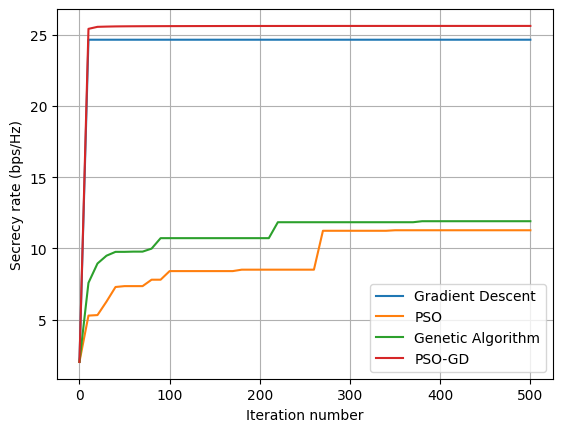

In [35]:
iterations = range(0, num_cycles+10, 10)

# Plotting the data
plt.plot(iterations, GD_results, label='Gradient Descent')
plt.plot(iterations, PSO_results, label='PSO')
plt.plot(iterations, GA_results[0:len(iterations)], label='Genetic Algorithm')
plt.plot(iterations, PSO_GD_results, label='PSO-GD')

plt.xlabel('Iteration number')
plt.ylabel('Secrecy rate (bps/Hz)')
plt.grid(True)
plt.legend()
plt.show()


In [36]:
# Best results of each methods
print("Best Secrecy Rate GD:", max(GD_results))
print("Best Secrecy Rate PSO:", max(PSO_results))
print("Best Secrecy Rate GA:", max(GA_results))
print("Best Secrecy Rate PSO-GD:", max(PSO_GD_results))

Best Secrecy Rate GD: [24.6548294]
Best Secrecy Rate PSO: [11.27448635]
Best Secrecy Rate GA: [17.00556469]
Best Secrecy Rate PSO-GD: [25.62364522]
